In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/My Drive/Airlines'

/content/drive/My Drive/Airlines


## Load data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('data/Invistico_Airline.csv')
df.shape

(129880, 23)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Seat comfort                       129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Food and drink                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Inflight wifi service              1298

In [ ]:
df.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,2,4,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,0,2,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,2,0,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,3,4,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,4,3,4,2,2,0,2,4,2,5,0,0.0


## EDA & Datensatz vorbereiten

Ist die Zielvariable des Datensatzes stark ungleich verteilt? Nein, kein weiteres Bearbeiten in dieser Hinsicht notwendig.

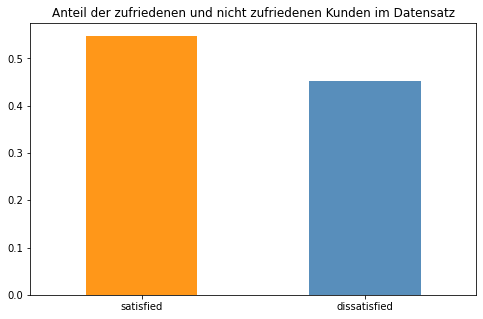

In [ ]:
fig = plt.figure(figsize = (8,5))
df.satisfaction.value_counts(normalize = True).plot(kind='bar', color= ['darkorange','steelblue'], alpha = 0.9, rot=0)
plt.title('Anteil der zufriedenen und nicht zufriedenen Kunden im Datensatz')
plt.show()

### Ausreißer entfernen

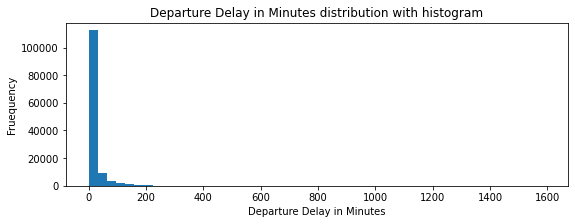

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


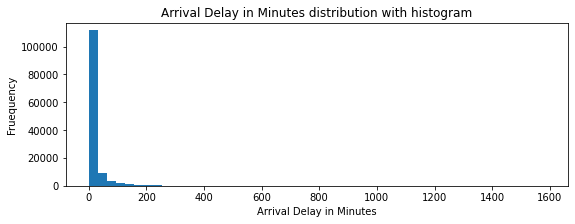

In [ ]:
def plot_hist(variable):
    plt.figure(figsize=(9,3))
    plt.hist(df[variable],bins=50)
    plt.xlabel(variable)
    plt.ylabel("Fruequency")
    plt.title("{} distribution with histogram".format(variable))
    plt.show()

outlier_cats = ['Departure Delay in Minutes', 'Arrival Delay in Minutes']
for n in outlier_cats:
  plot_hist(n)

In [ ]:
#Interquartilsabstand messen
Q1 = df[['Departure Delay in Minutes', 'Arrival Delay in Minutes']].quantile(0.25)
Q3 = df[['Departure Delay in Minutes', 'Arrival Delay in Minutes']].quantile(0.75)
IQR = Q3 - Q1
print('Interquartilsabstand:\n', IQR, '\n', 'Erstes Quartil:\n', Q1, '\n', 'Drittes Quartil:\n', Q3)

Interquartilsabstand:
 Departure Delay in Minutes    12.0
Arrival Delay in Minutes      13.0
dtype: float64 
 Erstes Quartil:
 Departure Delay in Minutes    0.0
Arrival Delay in Minutes      0.0
Name: 0.25, dtype: float64 
 Drittes Quartil:
 Departure Delay in Minutes    12.0
Arrival Delay in Minutes      13.0
Name: 0.75, dtype: float64


Entferne Extremwerte wie Verspätungen über 200 Minuten

In [ ]:
df = df[~((df['Departure Delay in Minutes'] > 200))]
df = df[~((df['Arrival Delay in Minutes'] > 200))]
df.shape

(128583, 23)

In [ ]:
df.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,2,4,2,3,3,0,3,5,3,2,0,0.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,2,0,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,3,4,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,4,3,4,2,2,0,2,4,2,5,0,0.0
5,satisfied,Male,Loyal Customer,30,Personal Travel,Eco,1894,0,0,0,3,2,0,2,2,5,4,5,5,4,2,0,0.0


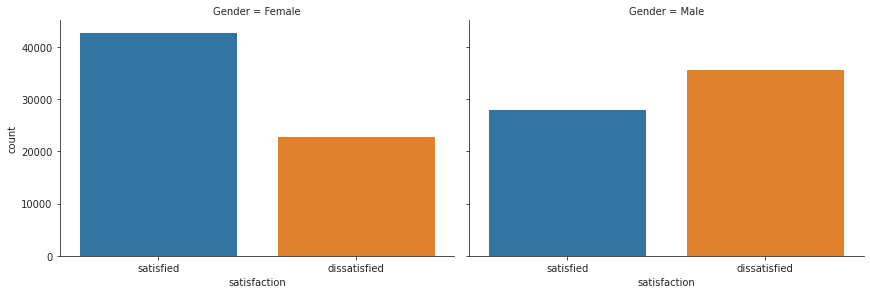

In [ ]:
with sns.axes_style(style='ticks'):
    g = sns.catplot(x="satisfaction", col="Gender", col_wrap=2, data=df, kind="count", height=4, aspect=1.5)  

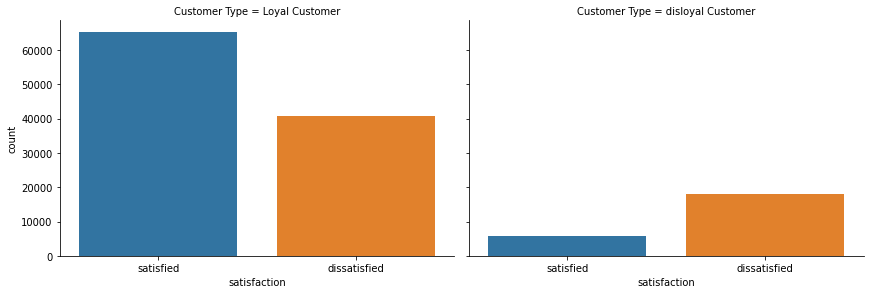

In [ ]:
 g = sns.catplot(x="satisfaction", col="Customer Type", col_wrap=2, data=df, kind="count", height=4, aspect=1.5)

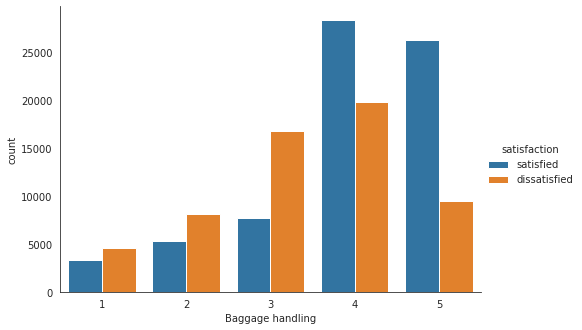

In [ ]:
with sns.axes_style(style='ticks'):
    g = sns.catplot(x="Baggage handling", hue="satisfaction", data=df, kind="count", height=4.5, aspect=1.5)

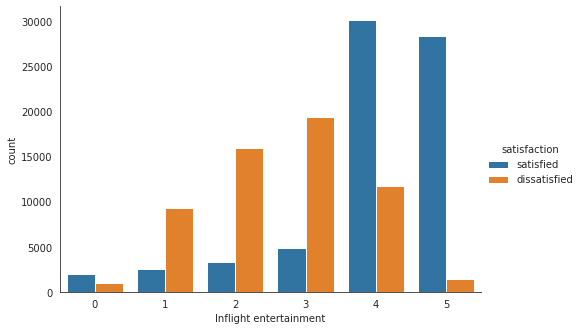

In [ ]:
with sns.axes_style('white'):
    g = sns.catplot(x="Inflight entertainment", hue="satisfaction", data=df, kind="count", height=4.5, aspect=1.5)

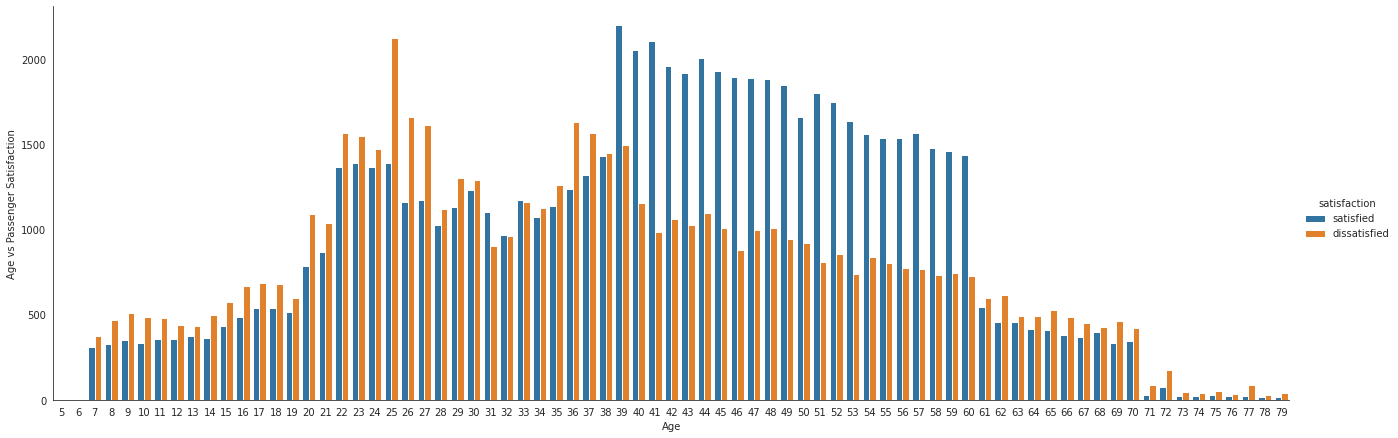

In [ ]:
with sns.axes_style('white'):
    g = sns.catplot(x="Age", data=df, height=6, aspect=3.0, kind='count', hue='satisfaction', order=range(5, 80))
    g.set_ylabels('Age vs Passenger Satisfaction')

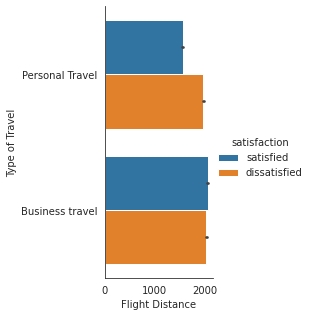

In [ ]:
with sns.axes_style('white'):
    g = sns.catplot(x="Flight Distance", y="Type of Travel", hue="satisfaction", data=df, kind="bar", height=4.5, aspect=.8)

Kategorische Variablen encoden und NAs in *Arrival Delay in Minutes* durch Median-Wert (hier: 0) ersetzen:

In [ ]:
# Check the list of categorical variables
df.select_dtypes(include=['object']).columns

Index(['satisfaction', 'Gender', 'Customer Type', 'Type of Travel', 'Class'], dtype='object')

In [ ]:
def transform_gender(x):
    if x == 'Female':
        return 1
    elif x == 'Male':
        return 0
    else:
        return -1
    
def transform_customer_type(x):
    if x == 'Loyal Customer':
        return 1
    elif x == 'disloyal Customer':
        return 0
    else:
        return -1
    
def transform_travel_type(x):
    if x == 'Business travel':
        return 1
    elif x == 'Personal Travel':
        return 0
    else:
        return -1
    
def transform_class(x):
    if x == 'Business':
        return 2
    elif x == 'Eco Plus':
        return 1
    elif x == 'Eco':
        return 0    
    else:
        return -1
    
def transform_satisfaction(x):
    if x == 'satisfied':
        return 1
    elif x == 'dissatisfied':
        return 0
    else:
        return -1
    
def process_data(df):
    df['Gender'] = df['Gender'].apply(transform_gender)
    df['Customer Type'] = df['Customer Type'].apply(transform_customer_type)
    df['Type of Travel'] = df['Type of Travel'].apply(transform_travel_type)
    df['Class'] = df['Class'].apply(transform_class)
    df['satisfaction'] = df['satisfaction'].apply(transform_satisfaction)
    df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median(), inplace = True)
    
    return df

df = process_data(df)

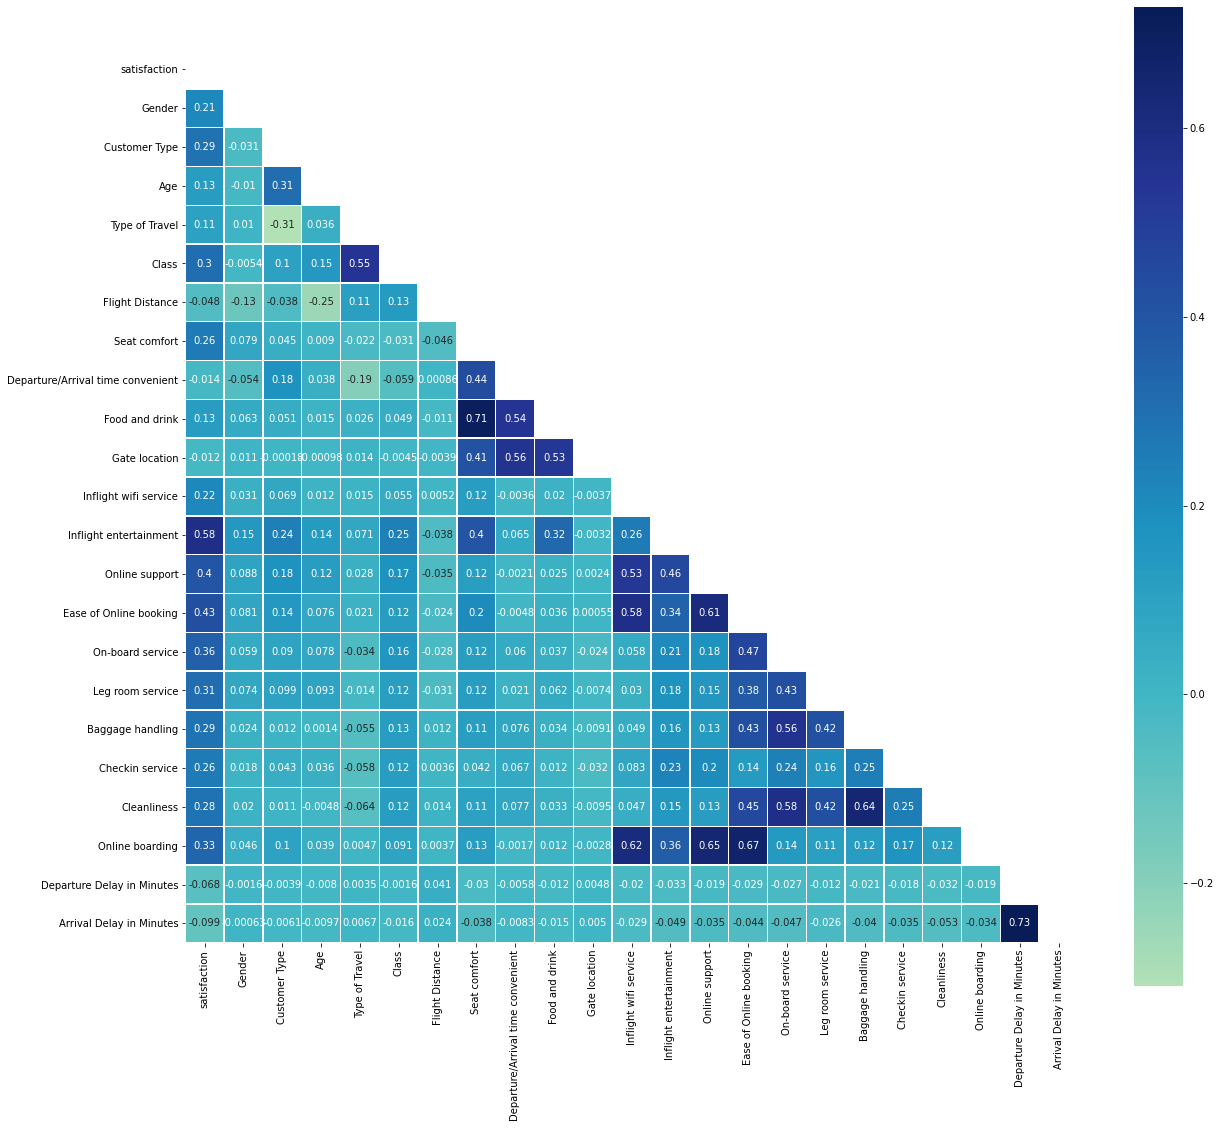

In [ ]:
corr = df.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap="YlGnBu", center=0,
            square=True, linewidths=.5)

## Erstelle Train-Valid-Test-Split

In [ ]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
train_set.to_csv(path_or_buf='data/train_set.csv', index=False)
test_set.to_csv(path_or_buf='data/test_set.csv', index=False)

In [ ]:
train_set = pd.read_csv('data/train_set.csv')
train_set.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,0,0,1,42,1,0,1304,2,4,4,4,2,2,2,2,3,3,4,2,4,2,0,0.0
1,1,0,1,57,1,2,844,1,1,1,1,2,4,5,4,4,4,4,4,4,3,18,19.0
2,1,0,1,39,1,0,1716,4,2,2,2,4,4,4,4,1,4,3,1,3,4,1,0.0
3,0,1,1,42,1,2,1177,2,5,3,5,3,4,4,2,2,2,2,2,2,2,11,19.0
4,1,1,1,39,1,2,2017,3,3,3,3,4,4,5,5,5,5,5,4,5,5,7,29.0


In [ ]:
test_set = pd.read_csv('data/test_set.csv')
test_set.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,0,0,0,26,1,2,2654,1,1,1,3,1,1,1,1,4,3,5,4,5,1,0,0.0
1,1,0,1,50,1,2,2429,3,3,3,3,2,5,4,4,4,4,4,5,4,5,0,0.0
2,1,1,1,52,0,0,973,4,4,4,4,3,5,5,5,5,5,5,4,5,2,0,0.0
3,1,1,1,24,0,0,866,1,1,1,1,3,5,4,4,4,4,4,3,4,4,11,1.0
4,0,0,1,53,1,1,2982,2,3,3,3,2,2,2,2,3,3,4,3,4,2,1,12.0


In [ ]:
print(len(df), len(train_set), len(test_set), (len(train_set)+len(test_set)))

128583 102866 25717 128583


Checken, ob Verteilung der Variable *satisfaction* in Train und Test-Set gleich ist: Ist der Fall (s. unten)

In [ ]:
from collections import Counter
a1 = Counter(train_set['satisfaction'])
a1[0]/(a1[0]+(a1[1]))

0.451519452491591

In [ ]:
a2 = Counter(test_set['satisfaction'])
a2[0]/(a2[0]+(a2[1]))

0.45044134230275695

## Feature Selection

### Chi-Quadrat

In [ ]:
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(df)
modified_data = pd.DataFrame(r_scaler.transform(df), columns=df.columns)
modified_data.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,1.0,1.0,1.0,0.743590,0.0,0.0,0.039450,0.0,0.0,0.0,0.4,0.4,0.8,0.25,0.6,0.6,0.0,0.50,1.00,0.6,0.4,0.0,0.0
1,1.0,1.0,1.0,0.102564,0.0,0.0,0.383119,0.0,0.0,0.0,0.6,0.4,0.0,0.25,0.4,0.6,0.6,0.75,0.75,0.8,0.4,0.0,0.0
2,1.0,1.0,1.0,0.679487,0.0,0.0,0.105138,0.0,0.0,0.0,0.6,0.6,0.8,0.50,0.2,0.2,0.0,0.00,0.75,0.2,0.6,0.0,0.0
3,1.0,1.0,1.0,0.807692,0.0,0.0,0.055780,0.0,0.0,0.0,0.6,0.8,0.6,0.75,0.4,0.4,0.0,0.25,0.75,0.4,1.0,0.0,0.0
4,1.0,0.0,1.0,0.294872,0.0,0.0,0.338349,0.0,0.0,0.0,0.6,0.4,0.0,0.25,0.4,1.0,0.8,1.00,1.00,0.8,0.4,0.0,0.0


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='satisfaction']
y = modified_data[['satisfaction']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Gender', 'Customer Type', 'Class', 'Inflight entertainment',
       'Online support', 'Ease of Online booking', 'On-board service',
       'Leg room service', 'Checkin service', 'Online boarding'],
      dtype='object')


### Wrapper Methode (in Arbeit nicht aufgeführt)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = df.drop('satisfaction', axis=1)
y = df['satisfaction']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Seat comfort', 'Inflight entertainment', 'Online support', 'Ease of Online booking']
[0.03112207 0.04292163 0.0313513  0.02687916 0.03665684 0.03540872
 0.1375453  0.02313689 0.04013795 0.02060466 0.01696653 0.19479068
 0.06690833 0.06802435 0.04366775 0.04376064 0.02917221 0.02519622
 0.02347665 0.03435421 0.01332053 0.01459736]


### Permutation Importance (in Arbeit nicht aufgeführt)

In [ ]:
!pip install eli5

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf(n_estimators=100, random_state=0).fit(X,y),random_state=1).fit(X,y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.1475 ± 0.0011,Seat comfort
0.0666 ± 0.0005,Customer Type
0.0534 ± 0.0011,Inflight entertainment
0.0399 ± 0.0008,Gender
0.0322 ± 0.0003,Online support
0.0321 ± 0.0011,Checkin service
0.0290 ± 0.0007,Type of Travel
0.0240 ± 0.0005,Baggage handling
0.0205 ± 0.0009,Cleanliness
0.0200 ± 0.0005,Online boarding


Nach dem Durchführen der verschiedenen Methoden, ergeben sich folgende wichtige Features:

'Gender', 'Customer Type', 'Class', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Checkin service', 'Online boarding'

'Seat comfort', 'Inflight entertainment', 'Online support', 'Ease of Online booking'

'Seat Comfort', 'Customer Type', 'Inflight Entertainment', 'Gender', 'Online Support', 'Checkin Service', 'Type of Travel', 'Baggage Handling', 'Cleanliness', 'Online Boarding'

In [ ]:
a = ['Gender', 'Customer type', 'Class', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Checkin service', 'Online boarding']
b = ['Seat comfort', 'Inflight entertainment', 'Online support', 'Ease of Online booking']
c = ['Seat comfort', 'Customer type', 'Inflight entertainment', 'Gender', 'Online support', 'Checkin service', 'Type of travel', 'Baggage handling', 'Cleanliness', 'Online boarding']

list(set(b) & set(a))


['Ease of Online booking', 'Inflight entertainment', 'Online support']

In [ ]:
list(set(c) & set(b))

['Inflight entertainment', 'Online support', 'Seat comfort']

In [ ]:
list(set(a) & set(c))

['Gender',
 'Inflight entertainment',
 'Customer type',
 'Checkin service',
 'Online boarding',
 'Online support']

Die 8 wichtigsten Feature scheinen demnach zu sein:

Seat Comfort, Inflight Entertainment, Online Support, Ease of Online Booking, Gender, Customer Type, Online Boarding, Checkin service

Im Weiteren Verlauf könnte mit dieser Information ein Modell mit weniger Features gebaut werden.